In [83]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2023-12-12
# @Filename: final_report.ipynb
# work.

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import math

import pandas as pd

In [84]:
# Data Preparation
# Pantheon: SN Ia Pantheon data

file_lcparam_full_long = "./Pantheon/lcparam_full_long.txt"
file_sys_full_long = "./Pantheon/sys_full_long.txt"

open_lcparam_full_long = open(file_lcparam_full_long, "r")
open_sys_full_long = open(file_sys_full_long, "r")

df_lcparam_full_long = pd.read_csv(file_lcparam_full_long, sep = ' ')
df_sys_full_long = pd.DataFrame(open_sys_full_long)

In [85]:
# zcmb, mb 추출
df_lcparam_full_long = df_lcparam_full_long.iloc[:,[1,4]]
df_sys_full_long[0] = df_sys_full_long[0].str.replace(pat=r'\n', repl=r'', regex=True)

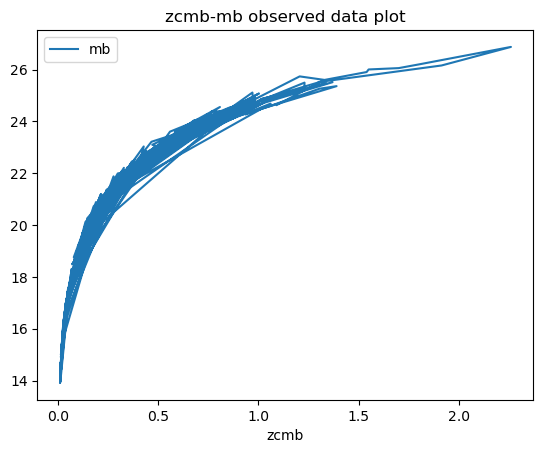

In [86]:
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.show()


In [87]:
import scipy.integrate as spi
import math

def DL_func(z_list, H0, Om0, OmL):
    res_list = []
    for z in z_list:
        def h_func(z):
            h = np.sqrt((OmL + Om0*(1+z)**3))
            return 1/h
        c = 299792 # km/sec
        qd_val, qd_err = spi.quad(h_func, 0, z)
        res = (c*(1+z)/H0)*qd_val
        res_list.append(res)
    return res_list

def DL_data(mb):
    # return value = mb
    results = []
    MB = 19.3
    for val in mb:
        res = 10**((val-MB)/5)
        results.append(res)

    return results


In [88]:
mb = list(df_lcparam_full_long["mb"])
z = list(df_lcparam_full_long["zcmb"])
DL = DL_data(mb)

In [89]:

def chi_squared_cov(y, model, cov):
    dm = []
    for i in range(len(y)):
        term1 = y[i]-model[i]
        dm.append(term1)
        
    dm_arr = np.array(dm)
    dm_transpose = dm_arr.T # transpose matrix of y
    # inverse of covariance matrix
    reg_param = 1e-3
    inv_cov = np.linalg.inv(cov + reg_param * np.eye(cov.shape[0]))
    #inv_cov = np.linalg.pinv(cov)
    term2 = np.dot(dm_transpose, inv_cov)
    chis_val = np.dot(term2, dm_arr)

    return chis_val

In [90]:
cov_ex = np.array(df_sys_full_long[0][1:1049])
cov = []
n=1
while True:
    cov_comp = list(map(float, df_sys_full_long[0][n:n+1048]))
    cov.append(cov_comp)
    n=n+1048
    #print(n)
    if n >1098305:
        break

cov.pop()
cov_arr = np.array(cov)

In [91]:
H0_old = 70
Om0_old = 0.3
OmL_old = 1-Om0_old
old_pos = [H0_old, Om0_old, OmL_old]

chis = chi_squared_cov(DL, DL_func(z, *old_pos), cov_arr)
old_likelihood = chis
print(old_likelihood)

3641130327359.6714


In [92]:
import random

# H0_old, Om0_old, OmL_old
# # make new positions
record = []
new_position_list = []
new_pos = []
new_likelihood_list = []
chis = []
for i in range(500):
    H0_new, Om0_new = H0_old + np.random.normal(0, 1), Om0_old+ np.random.normal(0, 0.01)
    OmL_new = 1 - Om0_new
    # step size
    new_pos = [H0_new, Om0_new, OmL_new]
    
    # Calculate the likelihood
    new_likelihood = chi_squared_cov(DL, DL_func(z, *new_pos), cov_arr)
    
    if new_likelihood > old_likelihood:
        new_position_list.append(new_pos)
        new_likelihood_list.append(new_likelihood)
        old_pos = new_pos
    elif new_likelihood < old_likelihood:
        rd = random.random()
        if rd < new_likelihood/old_likelihood:
            record.append(new_pos)
            new_position_list.append(new_pos)
            new_likelihood_list.append(new_likelihood)
            old_pos = new_pos
        else:
            record.append(old_pos)
            new_position_list.append(old_pos)
            new_likelihood_list.append(old_likelihood)
            old_pos = old_pos


In [93]:
minimum_chi = min(new_likelihood_list)
index = new_likelihood_list.index(minimum_chi)
print(new_likelihood_list[index])

3376094473899.5566


In [94]:
a_list = []
b_list = []
c_list = []
for i in range(len(new_position_list)):
    new_pos = new_position_list[i]
    a_list.append(new_pos[0])
    b_list.append(new_pos[1])
    c_list.append(new_pos[2])

peak_a = new_position_list[index][0]
peak_b = new_position_list[index][1]
peak_c = new_position_list[index][2]

peak_a = round(peak_a,2)
peak_b = round(peak_b,2)
peak_c = round(peak_c,2)

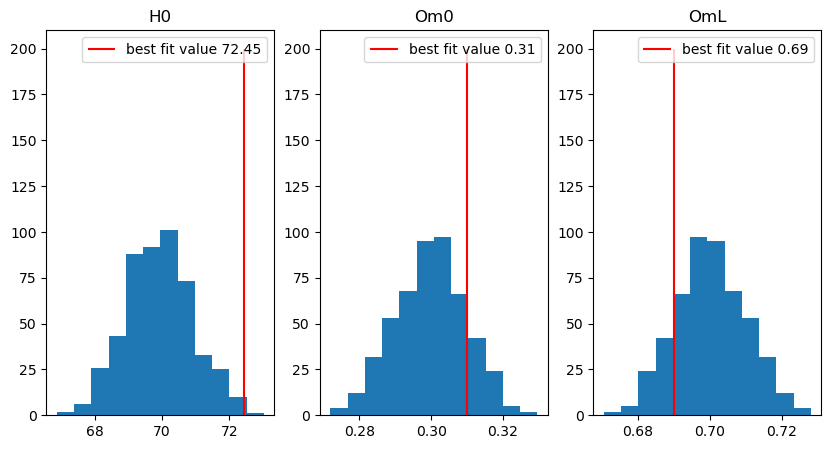

In [95]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist(a_list, bins=12)
plt.vlines(peak_a, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_a}")
plt.title('H0')
plt.legend()

plt.subplot(1,3,2)
plt.hist(b_list, bins=12)
plt.vlines(peak_b, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_b}")
plt.title('Om0')
plt.legend()

plt.subplot(1,3,3)
plt.hist(c_list, bins=12)
plt.vlines(peak_c, ymin=0, ymax=200, colors="r", label=f"best fit value {peak_c}")
plt.title('OmL')
plt.legend()
plt.show()

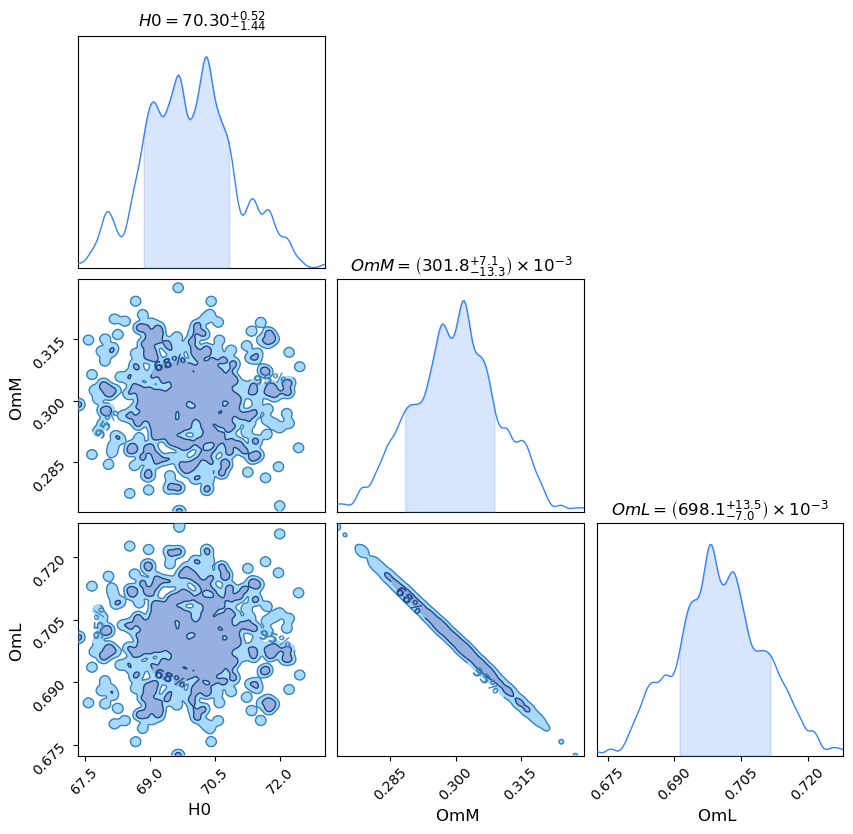

In [96]:
from chainconsumer import Chain, ChainConsumer, make_sample, PlotConfig

df = pd.DataFrame({"H0":a_list, "OmM":b_list, "OmL":c_list})
c = ChainConsumer()
c.add_chain(Chain(
    samples=df, 
    name="Pantheon SNla", 
    show_contour_labels=True,))
fig = c.plotter.plot()